**Reddit Discussions of Inflation: Potential Political Remifications**

I am interested in analyzing discourse surrounding inflation. I am particularly interested in whether or not this discourse has changed in the past few years. There has been a surge in inflation beginning in 2021 that is, as of 2024, just winding down. Many people have attributed President Biden's low approval ratings and Vice President Harris's loss in the November 2024 election to inflation. The voting habits of young voters have been discussed quite a bit so I wanted to analyze whether inflation played a role in influencing the voting of that demographic in particular. I decided to scrape reddit, a social media site that has a young user base, to see if conversations surrounding inflation had changed significantly during the Biden administration as opposed to before the Biden administration. 

In [1]:
import praw
import prawcore
import csv
import time
from datetime import datetime, timezone
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to C:\Users\Dana
[nltk_data]     Councilman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Scraping and Data Cleaning**

In [ ]:
reddit = praw.Reddit(
    client_id='WJPI0BIKA_hW4St4qU2hYA',
    client_secret='M7Ft3JvDpj8sgm9VVQBMgq6TFN3vDw',
    user_agent='Reddit Scraper by u/Interesting_Fig_5705'
)

subreddits = reddit.subreddit("politics+news+worldnews") #Scraped posts are top posts from the subreddits politics, news and world news
split_date = datetime(2021, 1, 20, tzinfo=timezone.utc) #Dividing the results into two PDFs, before and after Biden's inaguration which occured 1/20/2021

with open('reddit_posts_before.csv', mode='w', newline='', encoding='utf-8') as file_before, \
     open('reddit_posts_after.csv', mode='w', newline='', encoding='utf-8') as file_after:

    writer_before = csv.writer(file_before)
    writer_after = csv.writer(file_after)

    writer_before.writerow(['Title', 'Subreddit', 'Score', 'URL', 'Text', 'Date', 'Comments', 'Author'])
    writer_after.writerow(['Title', 'Subreddit', 'Score', 'URL', 'Text', 'Date', 'Comments', 'Author'])

    try:
        for submission in subreddits.top(limit=2500):  # 2500 posts scraped 
            try:
                title = submission.title
                subreddit = submission.subreddit
                score = submission.score
                url = submission.url
                text = submission.selftext
                post_date = datetime.fromtimestamp(submission.created_utc, tz=timezone.utc)
                author = submission.author.name if submission.author else "Deleted"

                comments = []
                submission.comments.replace_more(limit=5)  # Limit nested comment expansion
                for comment in submission.comments.list():
                    if 'inflation' in comment.body.lower():
                        comments.append(comment.body.strip())
                    #These  lines search through comments and tries to find comments that contain the word "inflation"
                comments_combined = " ||| ".join(comments) if comments else "No relevant comments"
                row = [title, subreddit, score, url, text, post_date, comments_combined, author]
                #The information of relevant posts are also recorded 
                if post_date < split_date:
                    writer_before.writerow(row)
                else:
                    writer_after.writerow(row)

                time.sleep(2)  # Add a delay to avoid rate-limiting
            except TooManyRequests as e:
                retry_after = int(e.response.headers.get('Retry-After', 10))
                print(f"Rate limit hit. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)  # Wait and retry the request
                continue

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [3]:
#The code below was me cleaning the data to perform textual analysis. I would ultimately remove stopwords and ignore the phrase "No relevant comments"
nltk.download('stopwords')
before_posts = pd.read_csv('reddit_posts_before.csv')['Comments'].dropna().astype(str)
before_posts = before_posts[before_posts != "No relevant comments"]
after_posts = pd.read_csv('reddit_posts_after.csv')['Comments'].dropna().astype(str)
after_posts = after_posts[after_posts != "No relevant comments"]

[nltk_data] Downloading package stopwords to C:\Users\Dana
[nltk_data]     Councilman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
len(before_posts)

251

In [7]:
before_posts.head(5)

27    American here. Can confirm. Learning the hard ...
35    Yup, the whole things seems pretty dystopian (...
49    FYI, In America, the number of money you typic...
51    It’s a mindset I’ll never understand. Where I’...
60    It's about wage compression. Over supply of lo...
Name: Comments, dtype: object

In [9]:
len(after_posts)

285

In [11]:
after_posts.head(5)

4     The Queen has been a constant in a rapidly cha...
5     My theory is that this started as a bluff and ...
7     Congress keeps giving themselves raises. Aren'...
10    Man, first Alex Jones texts, gas prices plumme...
16    It's not like Big Joe hasn't been busy up unti...
Name: Comments, dtype: object

Even removing posts where there were "No relevant comments" there are still over 250 relevant posts both before and after Biden's inaguration. This is sufficient to perform interesting analysis. 

**Textual Analysis** 

I will start by analyzing the posts before Biden's inaguration. 

In [13]:
# Load the CSV data
before_posts = pd.read_csv('reddit_posts_before.csv')['Comments'].dropna().astype(str)

# Define stopwords and custom exclusions
stop_words = set(stopwords.words('english'))  # Load NLTK stopwords
new_stops = {'relevant', 'comments', 'inflation', 'https'}  # Add custom stopwords
stop_words.update(new_stops)  # Update the stopwords set

clean_before = []

# Process each comment in `before_posts`
for post in before_posts:
    words = word_tokenize(post)  # Tokenize the text into words
    clean_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    clean_before.extend(clean_words)  # Add cleaned words to the main list

# Frequency distribution of the words
fdist = FreqDist(clean_before)

# Debug: Check the most common words
print("Most common words (debugging):", fdist.most_common(20))

'''
# Plot the frequency distribution
fdist.plot(20, title="Frequency of Words In Inflation-Related Reddit Comments Before Biden's Inaguration")
plt.show()
For the sake of brevity I have commented out this graph because I do not think you gain interesting insites from it compared to the bigrams and trigrams
'''

Most common words (debugging): [('people', 315), ('would', 256), ('money', 255), ('years', 209), ('us', 185), ('like', 173), ('get', 166), ('pay', 153), ('even', 150), ('much', 127), ('also', 115), ('wage', 112), ('cost', 112), ('going', 111), ('year', 110), ('one', 109), ('make', 105), ('government', 102), ('time', 98), ('economy', 98)]


'\n# Plot the frequency distribution\nfdist.plot(20, title="Frequency of Words In Inflation-Related Reddit Comments Before Biden\'s Inaguration")\nplt.show()\nFor the sake of brevity I have commented out this graph because I do not think you gain interesting insites from it compared to the bigrams and trigrams\n'

<FreqDist with 26122 samples and 29475 outcomes>


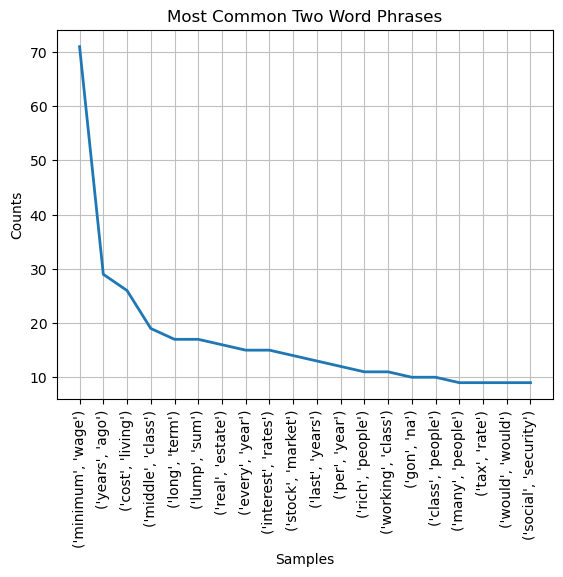

Axes(0.125,0.11;0.775x0.77)


In [15]:
bigrams = list(nltk.bigrams(clean_before))
fdist2 = FreqDist(bigrams)
x = fdist2.most_common(20)
print(fdist2)
print(fdist2.plot(20, title = "Most Common Two Word Phrases"))

<FreqDist with 28432 samples and 29474 outcomes>


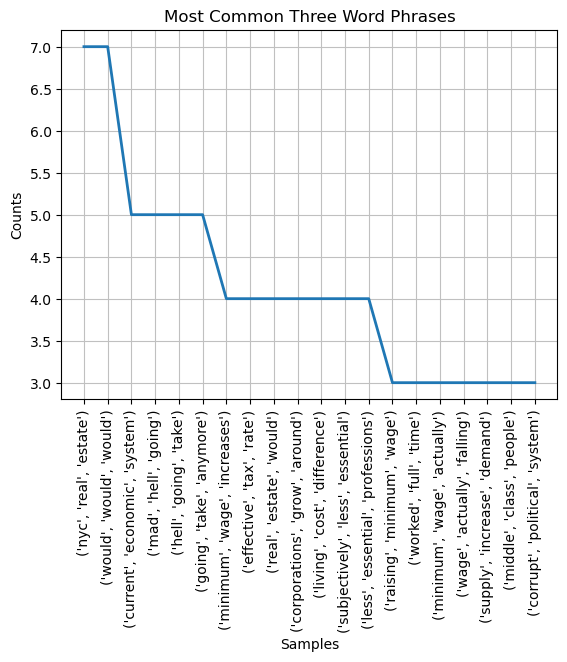

Axes(0.125,0.11;0.775x0.77)


In [17]:
trigrams = list(nltk.trigrams(clean_before))
fdist3 = FreqDist(trigrams)
x = fdist3.most_common(20)
print(fdist3)
print(fdist3.plot(20, title = "Most Common Three Word Phrases"))

The bigrams and trigrams offer interesting insight into which topics are discussed in conjunction with inflation. Discussions of minimum wage are fairly common, as are cost of living and real-estate. You do see some frustration with the current economic and political system. 

In [21]:
# Use a correct file path (replace with your actual path)
repo_path = r'reddit_posts_before.csv'  
search_words = ['inflation']  # List of search words
context_words = 2  # Number of surrounding words to capture

def inflation_talk_before(repo_path, search_words, context_words=2):
    '''This function tries to find what words surround "inflation" from the repository, excluding stopwords.'''
    

    # Combine search words into a single regex pattern (case-insensitive)
    search_pattern = '|'.join([re.escape(word) for word in search_words])  # Escape words for regex
    pattern = r'(?i)(\w+\s+){0,' + str(context_words) + r'}\b(?:' + search_pattern + r')\b(\s+\w+){0,' + str(context_words) + r'}'
    '''These lines of code search for words immediately surrounding the word "inflation" this is case insensitive and ignores punctuation'''
    
    # Counter to hold surrounding words
    surrounding_word_counter = Counter()

    try:
        # Open the speech text file directly
        with open(repo_path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()

            matches = re.findall(pattern, content)
           # print(f"Matches Found: {len(matches)}")  # Print the number of matches found
            #print(f"Matches: {matches}")  # Print the actual matches

            for match in matches:
                # Get the surrounding words
                surrounding_words = re.findall(r'\w+', ' '.join(match))

                # Exclude stopwords and update the counter
                filtered_words = [word.lower() for word in surrounding_words if word.lower() not in stop_words]
                surrounding_word_counter.update(filtered_words)

    except Exception as e:
        print(f"Could not read {repo_path}: {e}")

    return surrounding_word_counter

# Find surrounding words
surrounding_words_count = inflation_talk_before(repo_path, search_words, context_words)

# Print the most common surrounding words
if surrounding_words_count:
    for word, count in surrounding_words_count.most_common(10):  # Change 10 to however many you want to display
        print(f"'{word}' appears {count} times surrounding the words {', '.join(search_words)}.")
else:
    print(f"No surrounding words found for {', '.join(search_words)}.")


'cause' appears 9 times surrounding the words inflation.
'high' appears 7 times surrounding the words inflation.
'artificial' appears 6 times surrounding the words inflation.
'massive' appears 6 times surrounding the words inflation.
'hyper' appears 6 times surrounding the words inflation.
'like' appears 6 times surrounding the words inflation.
'also' appears 5 times surrounding the words inflation.
'grade' appears 5 times surrounding the words inflation.
'match' appears 4 times surrounding the words inflation.
'wage' appears 4 times surrounding the words inflation.


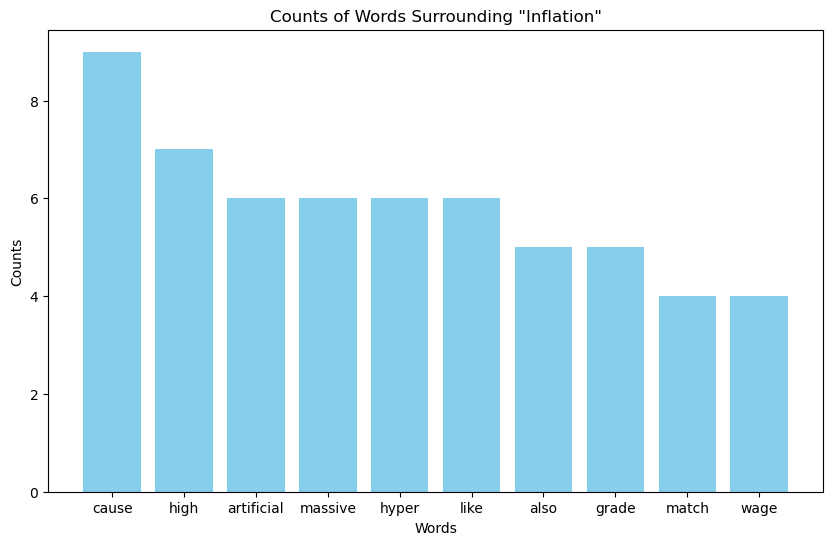

In [23]:
import matplotlib.pyplot as plt

words = ['cause', 'high', 'artificial', 'massive', 'hyper', 'like', 'also', 'grade', 'match', 'wage']
counts = [9, 7, 6, 6, 6, 6, 5, 5, 4, 4]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')

# Add labels and title
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Counts of Words Surrounding "Inflation"')

# Show the bar graph
plt.show()

When looking at words that directly surround the word "inflation" there are no unexpeccted insights. People are discussing the causes, why it is so high and how it effects wages). Now I will compare these findings to posts made during the Biden administration. 

In [42]:
# Load the CSV data
after_posts = pd.read_csv('reddit_posts_after.csv')['Comments'].dropna().astype(str)

clean_after = []

# Process each comment in `after_posts`
for post in after_posts:
    words = word_tokenize(post)  # Tokenize the text into words
    clean_words2 = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    clean_after.extend(clean_words2)  # Add cleaned words to the main list

# Frequency distribution of the words
fdist4 = FreqDist(clean_after)

# Debug: Check the most common words
print("Most common words (debugging):", fdist4.most_common(20))

''' Plot the frequency distribution
#fdist4.plot(20, title="Frequency of Words In Inflation-Related Reddit Comments After Biden's Inaguration")
#plt.show()
Commenting this out for the same reason I did previously
''''


Most common words (debugging): [('people', 611), ('money', 372), ('like', 358), ('would', 348), ('wage', 337), ('even', 307), ('get', 279), ('minimum', 276), ('prices', 272), ('years', 233), ('make', 231), ('one', 219), ('us', 219), ('going', 207), ('much', 205), ('also', 191), ('pay', 191), ('time', 189), ('go', 180), ('tax', 174)]


<FreqDist with 46678 samples and 53796 outcomes>


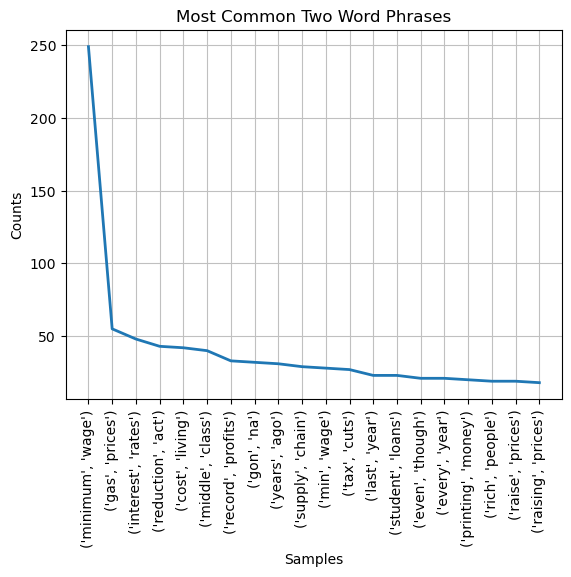

Axes(0.125,0.11;0.775x0.77)


In [44]:
bigrams2= list(nltk.bigrams(clean_after))
fdist5 = FreqDist(bigrams2)
x = fdist5.most_common(20)
print(fdist5)
print(fdist5.plot(20, title = "Most Common Two Word Phrases"))

<FreqDist with 52689 samples and 53795 outcomes>


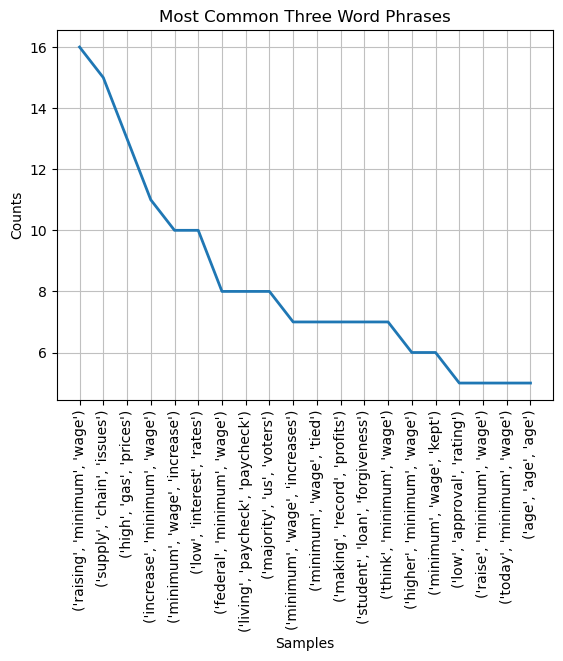

Axes(0.125,0.11;0.775x0.77)


In [46]:
trigrams2 = list(nltk.trigrams(clean_after))
fdist6 = FreqDist(trigrams2)
x = fdist6.most_common(20)
print(fdist6)
print(fdist6.plot(20, title = "Most Common Three Word Phrases"))

In [31]:
# Use a correct file path (replace with your actual path)
repo_path = r'reddit_posts_after.csv'  
search_words = ['inflation']  # List of search words
context_words = 2  # Number of surrounding words to capture

def inflation_talk_before(repo_path, search_words, context_words=2):
    '''This function tries to find what words surround "inflation" from the repository, excluding stopwords.'''
    

    # Combine search words into a single regex pattern (case-insensitive)
    search_pattern = '|'.join([re.escape(word) for word in search_words])  # Escape words for regex
    pattern = r'(?i)(\w+\s+){0,' + str(context_words) + r'}\b(?:' + search_pattern + r')\b(\s+\w+){0,' + str(context_words) + r'}'
    '''These lines of code search for words immediately surrounding the word "inflation" this is case insensitive and ignores punctuation'''
    
    # Counter to hold surrounding words
    surrounding_word_counter = Counter()

    try:
        # Open the speech text file directly
        with open(repo_path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()

            matches = re.findall(pattern, content)
            #print(f"Matches Found: {len(matches)}")  # Print the number of matches found
            #print(f"Matches: {matches}")  # Print the actual matches

            for match in matches:
                # Get the surrounding words
                surrounding_words = re.findall(r'\w+', ' '.join(match))

                # Exclude stopwords and update the counter
                filtered_words = [word.lower() for word in surrounding_words if word.lower() not in stop_words]
                surrounding_word_counter.update(filtered_words)

    except Exception as e:
        print(f"Could not read {repo_path}: {e}")

    return surrounding_word_counter

# Find surrounding words
surrounding_words_count = inflation_talk_before(repo_path, search_words, context_words)

# Print the most common surrounding words
if surrounding_words_count:
    for word, count in surrounding_words_count.most_common(10):  # Change 10 to however many you want to display
        print(f"'{word}' appears {count} times surrounding the words {', '.join(search_words)}.")
else:
    print(f"No surrounding words found for {', '.join(search_words)}.")

'act' appears 45 times surrounding the words inflation.
'high' appears 38 times surrounding the words inflation.
'cause' appears 21 times surrounding the words inflation.
'reduce' appears 19 times surrounding the words inflation.
'rising' appears 13 times surrounding the words inflation.
'caused' appears 12 times surrounding the words inflation.
'control' appears 11 times surrounding the words inflation.
'massive' appears 10 times surrounding the words inflation.
'understand' appears 10 times surrounding the words inflation.
'higher' appears 9 times surrounding the words inflation.


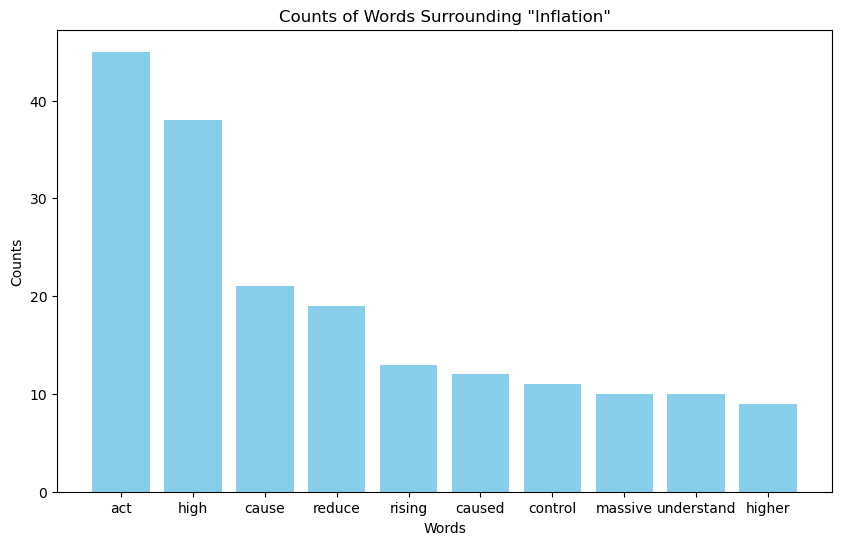

In [35]:
words = ['act', 'high', 'cause', 'reduce', 'rising', 'caused', 'control', 'massive', 'understand', 'higher']
counts = [45, 38, 21, 19, 13, 12, 11, 10, 10, 9]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')

# Add labels and title
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Counts of Words Surrounding "Inflation"')

# Show the bar graph
plt.show()

Overall, there are not significant differences in the words used during and before the Biden administration. During the Biden administration there was more discussion about supply chains, which makes sense as many attribute this inflation to Covid disruption supply chains. It is also worth noting that student loan debt and forgiveness was discussed more during the Biden administration. This makes sense, as student loans may play a role in people not feeling financially secure. Student loan forgiveness was also part of the Biden Administration's political goals. Unfortunately, the Supreme Court struck down some of the most generous provisions. I do think it's funny that the word "act" is the word that mostly commonly appears around the word "inflation." That is probably referring to the "Inflation Reduction Act" which was a piece of climate legislation. More than anything, that is a reflection of political discourse in the United States that often the literal words used are used more as a rhetorical tool than something that should be taken literally.  

**Sentiment Analysis** 

It is also useful to look at the overall sentiments of posts, to determine if posts are significant changes in sentiment over time. I will start by analyzing the posts from before the Biden presidency. 

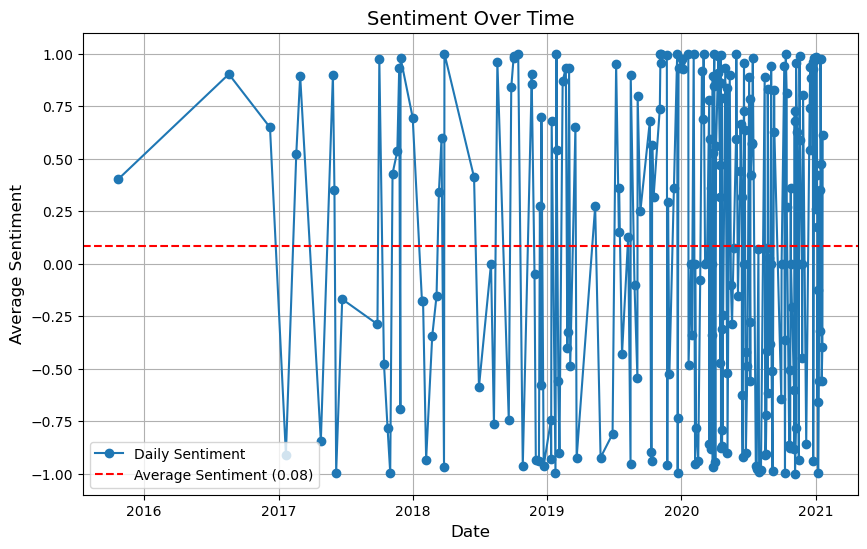

In [73]:
# Load the data
file_path = "reddit_posts_before.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()  # Ensure it's a copy

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Convert "Date" to datetime format
filtered_data.loc[:, "Date"] = pd.to_datetime(filtered_data["Date"], errors="coerce")
filtered_data = filtered_data.dropna(subset=["Date"])  # Drop rows with invalid dates

# Group by date and calculate average sentiment
sentiment_by_date = filtered_data.groupby("Date")["Sentiment"].mean()

# Calculate overall average sentiment
average_sentiment = filtered_data["Sentiment"].mean()

# Plot sentiment over time
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_date.index, sentiment_by_date, marker="o", label="Daily Sentiment")
plt.axhline(average_sentiment, color="red", linestyle="--", label=f"Average Sentiment ({average_sentiment:.2f})")
plt.title("Sentiment Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



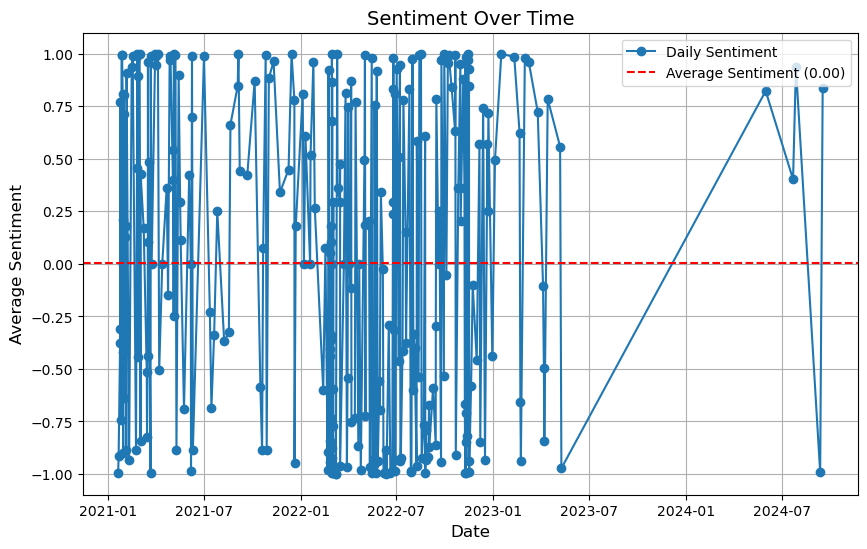

In [72]:
file_path = "reddit_posts_after.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()  # Ensure it's a copy

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Convert "Date" to datetime format
filtered_data.loc[:, "Date"] = pd.to_datetime(filtered_data["Date"], errors="coerce")
filtered_data = filtered_data.dropna(subset=["Date"])  # Drop rows with invalid dates

# Group by date and calculate average sentiment
sentiment_by_date = filtered_data.groupby("Date")["Sentiment"].mean()

# Calculate overall average sentiment
average_sentiment = filtered_data["Sentiment"].mean()

# Plot sentiment over time
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_date.index, sentiment_by_date, marker="o", label="Daily Sentiment")
plt.axhline(average_sentiment, color="red", linestyle="--", label=f"Average Sentiment ({average_sentiment:.2f})")
plt.title("Sentiment Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


The above graphs are graphing the semtiment of each post over time. But those graphs are very packed and not useful, so I will average the sentiments for each year and graph.

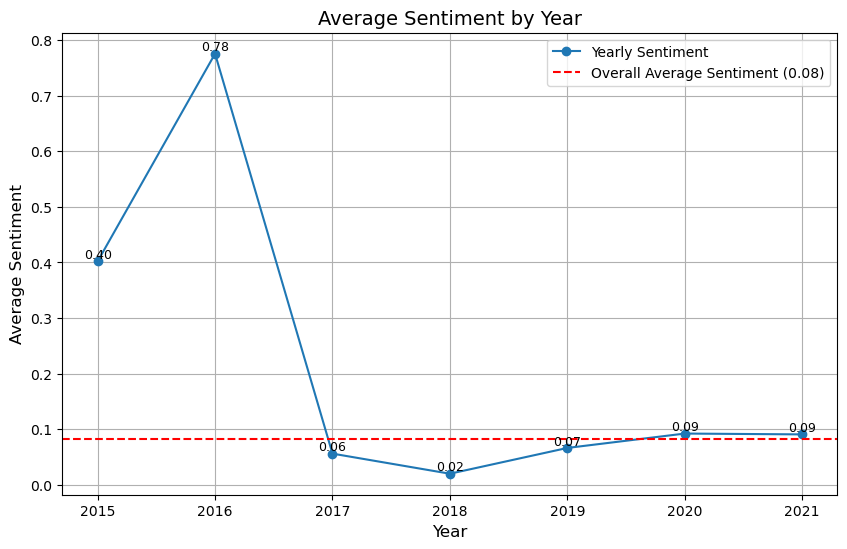

In [54]:
file_path = "reddit_posts_before.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()  # Ensure it's a copy

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Extract year directly from the "Date" column using string slicing
filtered_data.loc[:, "Year"] = filtered_data["Date"].str[:4].astype(int)

# Group by year and calculate average sentiment
sentiment_by_year = filtered_data.groupby("Year")["Sentiment"].mean()

# Calculate overall average sentiment
average_sentiment = filtered_data["Sentiment"].mean()

# Plot sentiment over years
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_year.index, sentiment_by_year, marker="o", label="Yearly Sentiment")
plt.axhline(average_sentiment, color="red", linestyle="--", label=f"Overall Average Sentiment ({average_sentiment:.2f})")

# Add labels for each year
for year, sentiment in sentiment_by_year.items():
    plt.text(year, sentiment, f"{sentiment:.2f}", ha="center", va="bottom", fontsize=9)

plt.title("Average Sentiment by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



Posts from 2015 and 2016 seem relatively positive, but that may be due to small sample size from those two years. The other years all have slightly positive tones. 2018 is the year with the lowest sentiment for its' posts, only .02. But from 2017 to 2021 the sentiment scores don't change much. 

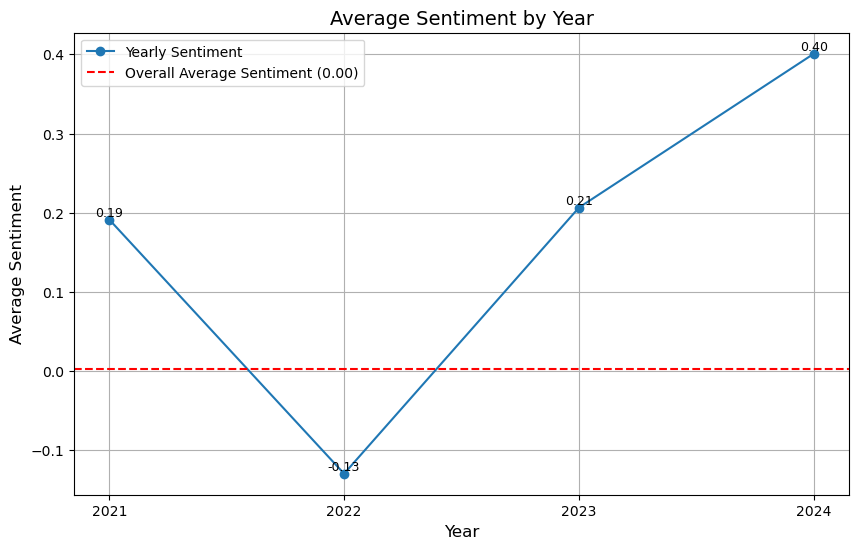

In [56]:
file_path = "reddit_posts_after.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()  # Ensure it's a copy

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Function to extract year from the "Date" column if it's a valid 4-digit integer
def extract_year(date):
    year_str = str(date)[:4]
    if year_str.isdigit():  # Check if the first 4 characters are digits
        return int(year_str)
    return None  # Return None if not a valid year

# Apply the function to extract the year
filtered_data.loc[:, "Year"] = filtered_data["Date"].apply(extract_year)

# Drop rows where the year is invalid (None)
filtered_data = filtered_data.dropna(subset=["Year"])

# Group by year and calculate average sentiment
sentiment_by_year = filtered_data.groupby("Year")["Sentiment"].mean()

# Calculate overall average sentiment
average_sentiment = filtered_data["Sentiment"].mean()

# Plot sentiment over years
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_year.index, sentiment_by_year, marker="o", label="Yearly Sentiment")
plt.axhline(average_sentiment, color="red", linestyle="--", label=f"Overall Average Sentiment ({average_sentiment:.2f})")

# Add labels for each year
for year, sentiment in sentiment_by_year.items():
    plt.text(year, sentiment, f"{sentiment:.2f}", ha="center", va="bottom", fontsize=9)

# Adjust x-axis ticks to show only full years
plt.xticks(ticks=sentiment_by_year.index, labels=[str(int(year)) for year in sentiment_by_year.index])

# Set title and labels
plt.title("Average Sentiment by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



Average sentiment during the Biden administration was 0, compared to an average sentiment of .08 prior to that time. So, the posts are less positive than they were before Biden was inagurated. It is not a big difference, but enough to be noticible. 2021 actually had fairly positive posts. It is worth noting that 2022, the year of the midterm elections had by far the most negative posts with a sentiment score of -.13. 

The next piece of analysis will be seeing if there is a correlation between the sentiment of the posts and actual inflation rates. That will help see if negative sentiments regarding inflation is warranted. 

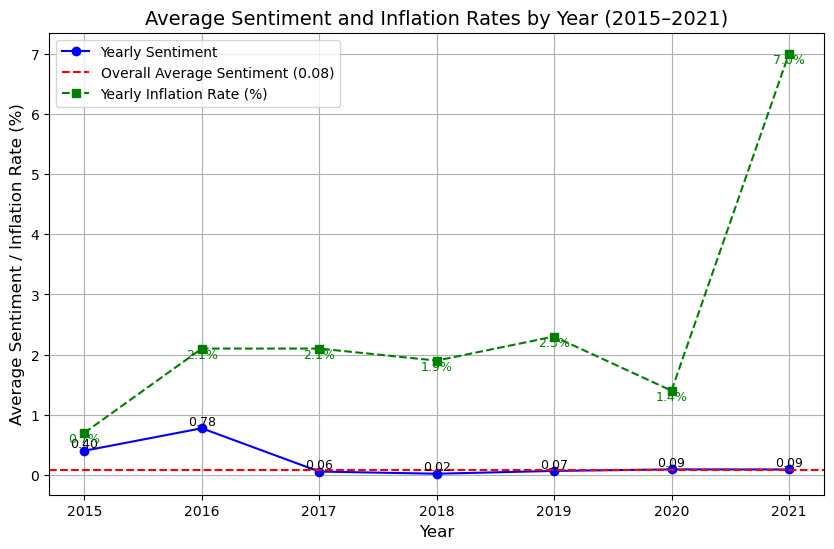

In [88]:
# Yearly inflation rates
inflation_rates = {
    2015: 0.7,
    2016: 2.1,
    2017: 2.1,
    2018: 1.9,
    2019: 2.3,
    2020: 1.4,
    2021: 7.0,
}

# Extract years and inflation values
inflation_years = list(inflation_rates.keys())
inflation_values = list(inflation_rates.values())

# Plot sentiment over years
plt.figure(figsize=(10, 6))
plt.plot(
    sentiment_by_year.index, sentiment_by_year, 
    marker="o", label="Yearly Sentiment", color="blue"
)
plt.axhline(
    average_sentiment, color="red", linestyle="--", 
    label=f"Overall Average Sentiment ({average_sentiment:.2f})"
)

# Add inflation rate line
plt.plot(
    inflation_years, inflation_values, 
    marker="s", linestyle="--", color="green", 
    label="Yearly Inflation Rate (%)"
)

# Add labels for sentiment values
for year, sentiment in sentiment_by_year.items():
    plt.text(year, sentiment, f"{sentiment:.2f}", ha="center", va="bottom", fontsize=9)

# Add labels for inflation rates
for year, inflation in inflation_rates.items():
    plt.text(year, inflation, f"{inflation:.1f}%", ha="center", va="top", fontsize=9, color="green")

# Customize plot
plt.title("Average Sentiment and Inflation Rates by Year (2015–2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Sentiment / Inflation Rate (%)", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()


Inflation was low in 2015 but it increased in 2016 and was fairly constant 2016-2019, a bit lower in 2020 (due to Covid) and quite high, at 7%, in 2021 due to Covid recovery. You do not see a huge correlation between sentiment surrounding inflation and actual inflation. The posts were more positive in 2015-2016 but remained fairly constant after that, despite a spike in inflation. 

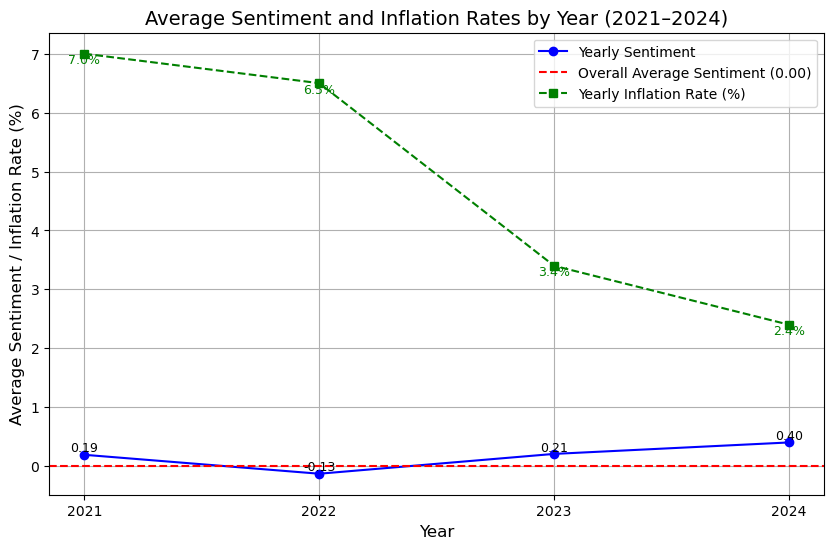

In [100]:
# Yearly inflation rates for 2021–2024
inflation_rates = {
    2021: 7.0,
    2022: 6.5,
    2023: 3.4,
    2024: 2.4,
}

# Extract years and inflation values
inflation_years = list(inflation_rates.keys())
inflation_values = list(inflation_rates.values())

# Plot sentiment over years
plt.figure(figsize=(10, 6))
plt.plot(
    sentiment_by_year.index, sentiment_by_year, 
    marker="o", label="Yearly Sentiment", color="blue"
)
plt.axhline(
    average_sentiment, color="red", linestyle="--", 
    label=f"Overall Average Sentiment ({average_sentiment:.2f})"
)

# Add inflation rate line
plt.plot(
    inflation_years, inflation_values, 
    marker="s", linestyle="--", color="green", 
    label="Yearly Inflation Rate (%)"
)

# Add labels for sentiment values
for year, sentiment in sentiment_by_year.items():
    plt.text(year, sentiment, f"{sentiment:.2f}", ha="center", va="bottom", fontsize=9)

# Add labels for inflation rates
for year, inflation in inflation_rates.items():
    plt.text(year, inflation, f"{inflation:.1f}%", ha="center", va="top", fontsize=9, color="green")

# Customize plot
plt.title("Average Sentiment and Inflation Rates by Year (2021–2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Sentiment / Inflation Rate (%)", fontsize=12)
plt.xticks(ticks=sorted(set(sentiment_by_year.index) | set(inflation_years)))
plt.legend()
plt.grid(True)

plt.show()



From 2021 to the present the relationship between inflation and sentiment score makes a bit more sense. In 2021 inflation was 7% and sentiment was weirdly positive. But, in 2022 when inflation was 6.5% the sentiment score was -.13. This could be explained by a delayed reaction to increased inflation. As inflation cooled in 2023 and 2024 we have seen an improvement in sentiment scores, which reinforces that, at least since 2021, there has been a correlation between inflation and sentiment surrounding inflation. 

**User Analysis** 

A final piece of analysis I will conduct is analyzing the sentiment of particularly active users, to see if negative sentiment is driven by specific individuals.

In [118]:
data = pd.read_csv("reddit_posts_before.csv")
# Filter the data to exclude rows where "Comments" reads "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"]

# Group by 'Author' and count the number of posts
author_post_counts = filtered_data.groupby("Author").size().reset_index(name="Post Count")

# Display the results sorted by post count in descending order
author_post_counts_sorted = author_post_counts.sort_values(by="Post Count", ascending=False)

# Show the top authors with the most posts
author_post_counts_sorted.head(20)


,Author,Post Count
23,Deleted,24
145,maxwellhill,11
22,DaFunkJunkie,5
121,hildebrand_rarity,5
26,DoremusJessup,4
129,itsbuzzpoint,3
79,Sumit316,3
135,kezzaNZ,3
105,chris-jjj,2
15,Brothanogood,2


**Users**

 A plurality of posts were made by accounts that have since been deleted, so I will have to remove that to analyze individual accounts.


In [128]:
data1 = pd.read_csv("reddit_posts_after.csv")
# Filter the data to exclude rows where "Comments" reads "No relevant comments"
filtered_data = data1[data["Comments"] != "No relevant comments"]

# Group by 'Author' and count the number of posts
author_post_counts = filtered_data.groupby("Author").size().reset_index(name="Post Count")

# Display the results sorted by post count in descending order
author_post_counts_sorted = author_post_counts.sort_values(by="Post Count", ascending=False)

# Show the top authors with the most posts
author_post_counts_sorted.head(26)

,Author,Post Count
29,Deleted,27
207,theladynora,6
85,PhilDesenex,4
39,ExactlySorta,4
11,Arpith2019,4
109,Twoweekswithpay,4
58,Jeffmister,3
126,burning_dawn,3
186,randalflagg,2
48,Hrekires,2


Next, I will analyze the sentiment of each user who made three or more posts.

In [59]:
# Load the dataset
file_path = "reddit_posts_before.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()

# Filter out rows where the Author is "deleted"
filtered_data = filtered_data[filtered_data["Author"] != "Deleted"]

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis to calculate sentiment scores
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Group by 'Author' and count the number of posts for each author
author_post_counts = filtered_data.groupby("Author").size().reset_index(name="Post Count")

# Filter authors with three or more posts
authors_with_3_or_more = author_post_counts[author_post_counts["Post Count"] >= 3]["Author"]

# Filter the original data for those authors
filtered_authors_data = filtered_data[filtered_data["Author"].isin(authors_with_3_or_more)]

# Group by 'Author' and calculate the average sentiment score for each author
author_sentiment = filtered_authors_data.groupby("Author")["Sentiment"].mean().reset_index()

# Rename columns for clarity
author_sentiment.columns = ["Author", "Average Sentiment"]

# Sort by average sentiment for better analysis
author_sentiment_sorted = author_sentiment.sort_values(by="Average Sentiment", ascending=False)

# Display the results
print(author_sentiment_sorted)



              Author  Average Sentiment
4       itsbuzzpoint           0.980867
6        maxwellhill           0.455764
2           Sumit316           0.357533
5            kezzaNZ           0.205400
1      DoremusJessup           0.139025
3  hildebrand_rarity          -0.027880
0       DaFunkJunkie          -0.094860


Prior to the Biden administration ,there are no users discussing the topic of inflation that stand out as very negative. Two users, hildebrand_rarity and DaFunkJunie are slightly negative, with scores of -.028 and -.094 respectively however they are only slightly negative. One users, itsbuzzpoint is actually quite positive with a score of .981. 

In [61]:
# Load the dataset
file_path = "reddit_posts_after.csv"
data = pd.read_csv(file_path)

# Filter out rows with "No relevant comments"
filtered_data = data[data["Comments"] != "No relevant comments"].copy()

# Filter out rows where the Author is "deleted"
filtered_data = filtered_data[filtered_data["Author"] != "Deleted"]

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis to calculate sentiment scores
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Group by 'Author' and count the number of posts for each author
author_post_counts = filtered_data.groupby("Author").size().reset_index(name="Post Count")

# Filter authors with three or more posts
authors_with_3_or_more = author_post_counts[author_post_counts["Post Count"] >= 3]["Author"]

# Filter the original data for those authors
filtered_authors_data = filtered_data[filtered_data["Author"].isin(authors_with_3_or_more)]

# Group by 'Author' and calculate the average sentiment score for each author
author_sentiment = filtered_authors_data.groupby("Author")["Sentiment"].mean().reset_index()

# Rename columns for clarity
author_sentiment.columns = ["Author", "Average Sentiment"]

# Sort by average sentiment for better analysis
author_sentiment_sorted = author_sentiment.sort_values(by="Average Sentiment", ascending=False)

# Display the results
print(author_sentiment_sorted)


            Author  Average Sentiment
6      theladynora           0.227783
1     ExactlySorta           0.167350
0       Arpith2019           0.034175
2       Jeffmister          -0.006800
4  Twoweekswithpay          -0.080425
3      PhilDesenex          -0.098875
5     burning_dawn          -0.864000


There are a couple of interesting observations when comparing the sentiment of individuals prior to the Biden administration and during. First, the users who actively discuss this topic are different, there is no overlap between active users in the before group and the current group. In this case, 4/7 users are overall negative in their discussions, as opposed to 2/7 in the discussions before the Biden administration. Additionally, the user burning_dawn has sentiment score of -.864 which is very negative. Even the post positive sentiment score is only .223 compared to .981 in the before group. Out of curosity, I will see how the sentiment score of the posts is affected if I remove the user burning_dawn. 

In [63]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the dataset
file_path = "reddit_posts_after.csv"
data = pd.read_csv(file_path)

# Exclude rows where the "Author" matches either "Deleted" or "burning_dawn"
users_to_exclude = ["Deleted", "burning_dawn"]
filtered_data = data[~data["Author"].isin(users_to_exclude)].copy()

# Filter out rows with "No relevant comments"
filtered_data = filtered_data[filtered_data["Comments"] != "No relevant comments"]

# Ensure "Comments" column is treated as strings and handle missing values
filtered_data.loc[:, "Comments"] = filtered_data["Comments"].fillna("").astype(str)

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity
def get_sentiment(comment):
    return analyzer.polarity_scores(comment)["compound"]

# Apply sentiment analysis to calculate sentiment scores
filtered_data.loc[:, "Sentiment"] = filtered_data["Comments"].apply(get_sentiment)

# Calculate overall average sentiment
average_sentiment = filtered_data["Sentiment"].mean()

# Print the result
print(f"Overall Average Sentiment (excluding users {', '.join(users_to_exclude)}): {average_sentiment:.2f}")


Overall Average Sentiment (excluding users Deleted, burning_dawn): 0.03


When exclusing burning_dawn the overall sentiment score is .03, slightly positive as opposed to 0 exactly when burning_dawn is included. 

There are several conclusions that can be drawn from this analysis. First, while language did not change significantly in posts before and during the Biden administration the Inflation Reduction Act and student loan debt were two topics that were discussed more extensively during the Biden administration. Second, while the difference is small, posts made during the Biden administration are less positive than posts made after the Biden administration. At least during the Biden administration there appears to be relationship between the sentiment score of the posts and inflation itself. The posts were more negative during years in which inflation was high. Third, the most active users were overall more negative during the Biden administration. One user in particular, burning_dawn, was particularly negative. Therefore, it seems that Reddit discourse surrounding inflation was more negative during the Biden administration. If this is representative of other young voters, that lends credence to the theory that inflation was a huge factor in the fact that Democrats lost in 2024. 

Visit my Website: https://danacouncilman.github.io/Dana-Projects/

**Bibliography**
Year over year inflation statistics were taken from the following source: 
"Current US Inflation Rates: 2000-2024." US Inflation Calcuator. November 13, 2024. https://www.usinflationcalculator.com/inflation/current-inflation-rates/.

Reddit subreddits new, worldnews and politics were used to obtain post data. 
ChatGPT was used to help with Python syntax. 